In [2]:
import tensorflow as tf
import numpy as np
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() #incarca si imparte seturile de imagini

In [3]:
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


In [4]:
#CONVERTIM SI NORMAM VALORILE PIXELILOR DIN FLOAT IN VALORI INTRE 0 SI 1
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

x_train =x_train/ 255.0
x_test  =x_test/ 255.0

Designeul retelei neurale

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, AveragePooling2D

In [6]:
retea_licenta = Sequential() 
retea_licenta.add(AveragePooling2D(pool_size=(2, 2), input_shape=(28, 28, 1)))
retea_licenta.add(Flatten()) 
retea_licenta.add(Dense(32, activation=tf.nn.relu))
retea_licenta.add(Dense(10,activation=tf.nn.softmax))
retea_licenta.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d (AverageP  (None, 14, 14, 1)        0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 196)               0         
                                                                 
 dense (Dense)               (None, 32)                6304      
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 6,634
Trainable params: 6,634
Non-trainable params: 0
_________________________________________________________________


ANTRENAREA RETELEI

In [7]:
retea_licenta.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']) 
retea_licenta.fit(x=x_train,y=y_train, epochs=10)


Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.5026 - accuracy: 0.8653
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2564 - accuracy: 0.9270
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2165 - accuracy: 0.9381
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1897 - accuracy: 0.9455
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1712 - accuracy: 0.9505
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1569 - accuracy: 0.9550
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1462 - accuracy: 0.9575
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1373 - accuracy: 0.9602
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1287 - accuracy: 0.9629
Epoch 10/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.122

TESTAREA MODELULUI

In [8]:
retea_licenta.evaluate(x_test, y_test)

313/313 [==============================] - 1s 1ms/step - loss: 0.1330 - accuracy: 0.9602


[0.13304708898067474, 0.9602000117301941]

313/313 [==============================] - 0s 1ms/step


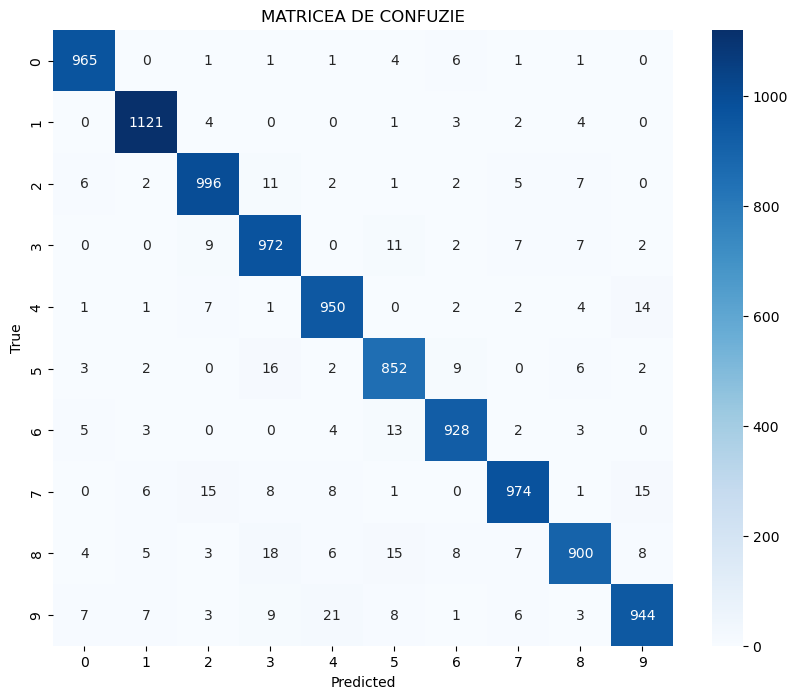

In [9]:
# Generate predictions for the test set
y_pred_probs = retea_licenta.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
labels = np.unique(y_test)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('MATRICEA DE CONFUZIE')
plt.show()

In [ ]:
NORMAREA VALORILOR PENTRU WEIGHT SI BIAS SI EXPORTAREA ACESTORA

In [10]:
def quantize_nbit(poza, numarul_de_biti, activare_normare=0, verbose=0):
    max_bit_val = (2**(numarul_de_biti-1))-1
    max_val     = np.max(np.abs(poza))
    if activare_normare > 0:
        normare = activare_normare
    else :
        normare   = max_bit_val / max_val 
    if verbose:
        print('Quantizing to +/- {}, scaling by {}'.format(max_bit_val, normare))
        
    iesire_int = np.around(poza * normare)
    iesire = iesire_int /  normare
    
    return iesire, iesire_int, normare

import IPython.display as dp
def print_nowrap(s):
    display(dp.HTML("<style>.nowrap{white-space:nowrap;}</style><span class='nowrap'>" +s+ "</span>"))

In [16]:
numarul_de_biti= 8           
normat        = [0,0,0,0]
normat_scala  = [0,0,0,0]

print(retea_licenta.layers)

for l,layer in enumerate(retea_licenta.layers):
    if len(layer.weights)>0:
        w,b = layer.weights
        w,b = w.numpy(), b.numpy()
        print('Layer {} - Array Shape/Range: Weights = {}, Biases = {}'.format(l, w.shape, b.shape))
        w_q, w_qi, normare = quantize_nbit(w, numarul_de_biti, verbose=1)
        b_q, b_qi, _     = quantize_nbit(b, numarul_de_biti, activare_normare=normare)
        
        num_w, num_neuron = w.shape
        
        s = "localparam signed [{}:0] B_ARRAY_L{} [0:{}] = '{{ {} }};".format(numarul_de_biti-1, l, num_neuron-1, ', '.join(str(int(e)) for e in b_qi))
        print_nowrap(s)
        
        s = "localparam signed [{}:0] W_ARRAY_L{} [0:{}] [0:{}] = '{{<br>".format(numarul_de_biti-1, l, num_neuron-1, len(w_qi[:,0])-1)
        for n in range(num_neuron) :
            
            s += "{{ {} }},<br>".format(', '.join(str(int(e)) for e in w_qi[:,n]))
        s = s[0:-5] # remove last comma
        s += "<br>};<br>"
        print_nowrap(s)
        
            
        normat[l]       = (w_qi, b_qi)
        normat_scala[l] = (w_q,  b_q)
        

[<keras.layers.pooling.average_pooling2d.AveragePooling2D object at 0x0000020916A41870>, <keras.layers.reshaping.flatten.Flatten object at 0x0000020916A406A0>, <keras.layers.core.dense.Dense object at 0x0000020914B4CC10>, <keras.layers.core.dense.Dense object at 0x0000020916A45CF0>]
Layer 2 - Array Shape/Range: Weights = (196, 32), Biases = (32,)
Quantizing to +/- 127, scaling by 64.11115945435601


Layer 3 - Array Shape/Range: Weights = (32, 10), Biases = (10,)
Quantizing to +/- 127, scaling by 28.96401746552032


CONVERTIREA UNEI IMAGINI IN VECTOR PENTRU VERILOG

In [26]:
import cv2
import numpy as np

# INCARCA IMAGINEA INTR-O MATRICE CU NIVELURI DE GRI
img = cv2.imread('SASE.jpg', cv2.IMREAD_GRAYSCALE)

# DIMENSIONEAZA IN 28X28 PIXELI
resized_img = cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA)

# CONVERTESTE DIN FORMA MATRICEALA IN VECTOR
vector_img = resized_img.flatten()

# NORMEAZA VALORILE PIXELILOR INTRE 0 SI 127
normalized_vector = (vector_img * (127.0 / 255.0)).astype(np.uint8)

# AFISEAZA VECTORUL NORMAT PENTRU A FI LUAT CU COPY PASTE PENTRU VERILOG
print("logic signed [7:0] test_data_X [0:783] ='{")

print(','.join(str(val) for val in normalized_vector))
print("};")


logic signed [7:0] test_data_X [0:783] ='{
0,0,0,0,0,0,0,0,0,11,0,0,1,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,10,89,78,26,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,59,116,124,58,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,69,117,127,127,93,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,82,127,122,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,111,127,61,4,4,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,127,118,25,2,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,70,124,86,2,1,0,2,0,0,0,3,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,3,3,93,127,85,3,0,0,0,3,0,5,0,1,5,0,0,5,0,0,0,0,0,1,0,0,0,1,0,0,121,127,70,3,0,3,0,0,0,0,1,26,38,0,6,0,0,0,0,0,0,0,1,0,2,0,0,7,124,122,41,0,0,0,4,0,5,0,54,124,126,43,4,0,0,0,0,0,2,0,0,0,0,0,5,41,123,123,24,0,0,0,10,1,19,72,127,117,127,113,30,0,0,0,0,0,2,0,0,0,1,0,3,51,125,117,7,2,6,0,0,0,72,127,103,31,96,127,42,12,0,0,0,0,0,0,3,0,3,0,0,44,122,99,0,0,2,0,0,30,101,127,56,0,101,124,49,0,0,0,0,0,0,0,